In [1]:
#회고 2주차 내용
# MNIST
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader

train_dataset=datasets.MNIST(root="MNIST_data/",train=True, # 학습 데이터
                             #Totenser함수를 사용하면 0~1 사이의 실수들로 바꿔주면서 계산하기 쉽게 만들어준다. 그리고 텐서타입으로 반환해줌
                             transform=transforms.ToTensor(), # 0~255까지의 값을 0~1 사이의 값으로 변환시켜줌
                             download=True)
test_dataset=datasets.MNIST(root="MNIST_data/",train=False, # 테스트 데이
                            transform=transforms.ToTensor(), # 0~255까지의 값을 0~1 사이의 값으로 변환시켜줌
                            download=True)

C:\Users\ANNA_TEST\anaconda3\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
print(len(train_dataset))

60000


In [3]:
print(len(test_dataset))

10000


In [4]:
train_dataset_size=int(len(train_dataset)*0.85)
validation_dataset_size=int(len(train_dataset)*0.15)

train_dataset,validation_dataset=random_split(train_dataset,[train_dataset_size,validation_dataset_size])

print(len(train_dataset), len(validation_dataset), len(test_dataset))

51000 9000 10000


In [5]:
class MyDeepLearningModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten=nn.Flatten()
        self.fc1=nn.Linear(784,256)
        self.relu=nn.ReLU()
        self.dropout=nn.Dropout(0.3)
        self.fc2=nn.Linear(256,10)

    def forward(self, data):
        data=self.flatten(data)
        data=self.fc1(data)
        data=self.relu(data)
        data=self.dropout(data)
        logits=self.fc2(data)
        return logits

In [6]:
BATCH_SIZE=32

train_dataset_loader=DataLoader(dataset=train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)

validation_dataset_loader=DataLoader(dataset=validation_dataset,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True)

test_dataset_loader=DataLoader(dataset=test_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=True)

In [7]:
model=MyDeepLearningModel()

loss_function=nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(model.parameters(), lr=1e-2)

In [8]:
def model_train(dataloader, model, loss_function, optimizer):

    model.train() # 신경망을 학습모드(모델 파라미터를 업데이트하는 모드로)로 전환

    train_loss_sum=train_correct=train_total=0
    total_train_batch=len(dataloader)

    for images, labels in dataloader:
        x_train=images.view(-1,28*28) # 처음 크기는 (batch_size, 1,28,28)인데 이걸 (batch_size, 784)로 변환
        y_train=labels

        outputs=model(x_train) # 입력 데이터에 대해 예측 값 계산
        loss=loss_function(outputs, y_train) # 모델 예측 값과 정답과의 오차인 손실함수 계산

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum+=loss.item()

        train_total+=y_train.size(0)
        train_correct+=((torch.argmax(outputs,1)==y_train)).sum().item()

    train_avg_loss=train_loss_sum/total_train_batch #학습 데이터 평균 오차 계산
    train_avg_accuracy=100*train_correct/train_total # 학습데이터 평균 정확도 게산

    return (train_avg_loss, train_avg_accuracy)

In [9]:
def model_evaluate(dataloader, model, loss_function, optimizer):

    model.eval() # 신경망을 추론모드로 전환

    with torch.no_grad(): # 미분 하지 않겠다는 코드 즉 모델 파라미터를 업데이트 시키지 않겠다는 의미

        val_loss_sum=val_correct=val_total=0
        total_val_batch=len(dataloader)

        for images, labels in dataloader: # images에는 MNIST 이미지, labels에는 0~9 정답 숫자

            x_val=images.view(-1,28*28) # 처음 크기는 (batch_size, 1,28,28)인데 이걸 (batch_size, 784)로 변환
            y_val=labels

            outputs=model(x_val)
            loss=loss_function(outputs, y_val)

            val_loss_sum+=loss.item()

            val_total+=y_val.size(0)

            val_correct+=((torch.argmax(outputs, 1)==y_val)).sum().item()

        val_avg_loss=val_loss_sum/total_val_batch # 검증데이터 평균 오차 계산
        val_avg_accuracy=100*val_correct/val_total # 검증 데이터 평균 정확도 계산

    return (val_avg_loss, val_avg_accuracy)

In [10]:
train_loss_list=[]
train_accuracy_list=[]

val_loss_list=[]
val_accuracy_list=[]

EPOCH=20

for epoch in range(EPOCH):

    #===========model train=============
    train_avg_loss, train_avg_accuracy=model_train(train_dataset_loader,
                                                   model,loss_function,
                                                   optimizer)
    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)
    #-----------------------------------


    #===========model evaluation========
    val_avg_loss, val_avg_accuracy=model_evaluate(validation_dataset_loader,
                                                  model, loss_function,
                                                  optimizer)

    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)

    print(f'epoch:{epoch}, train loss={train_avg_loss}, train accuracy={train_avg_accuracy}, val loss={val_avg_loss}, val accuracy={val_avg_accuracy}')

epoch:0, train loss=0.9801464274693912, train accuracy=77.03333333333333, val loss=0.4576594428496158, val accuracy=88.36666666666666
epoch:1, train loss=0.43575271577989144, train accuracy=87.72941176470589, val loss=0.3498166104950381, val accuracy=90.47777777777777
epoch:2, train loss=0.3644874161728652, train accuracy=89.60980392156863, val loss=0.30739057418091076, val accuracy=91.6
epoch:3, train loss=0.32238478469691584, train accuracy=90.82156862745099, val loss=0.27868536130544985, val accuracy=92.4
epoch:4, train loss=0.294447719761015, train accuracy=91.65882352941176, val loss=0.25568844720139994, val accuracy=92.91111111111111
epoch:5, train loss=0.27096652550157746, train accuracy=92.38823529411765, val loss=0.23941183722980902, val accuracy=93.16666666666667
epoch:6, train loss=0.2514003829415911, train accuracy=92.88235294117646, val loss=0.22217259458299224, val accuracy=93.84444444444445
epoch:7, train loss=0.2360796409692975, train accuracy=93.27450980392157, val los

In [11]:
def model_test(dataloader, model):

    model.eval()

    with torch.no_grad(): # 미분 하지 않겠다는 코드 즉 모델 파라미터를 업데이트 시키지 않겠다는 의미

        test_loss_sum=test_correct=test_total=0
        total_test_batch=len(dataloader)

        for images, labels in dataloader: # images에는 MNIST 이미지, labels에는 0~9 정답 숫자

            x_test=images.view(-1,28*28) # 처음 크기는 (batch_size, 1,28,28)인데 이걸 (batch_size, 784)로 변환
            y_test=labels

            outputs=model(x_test)
            loss=loss_function(outputs, y_test)

            test_loss_sum+=loss.item()

            test_total+=y_test.size(0)

            test_correct+=((torch.argmax(outputs, 1)==y_test)).sum().item()

        test_avg_loss=test_loss_sum/total_test_batch # 검증데이터 평균 오차 계산
        test_avg_accuracy=100*test_correct/test_total # 검증 데이터 평균 정확도 계산

    return (test_avg_loss, test_avg_accuracy)

In [12]:
test_loss,test_accuracy=model_test(test_dataset_loader, model)
print(f'accuracy:{test_accuracy}')
print(f'loss:{test_loss}')

accuracy:96.5
loss:0.12182765494817838


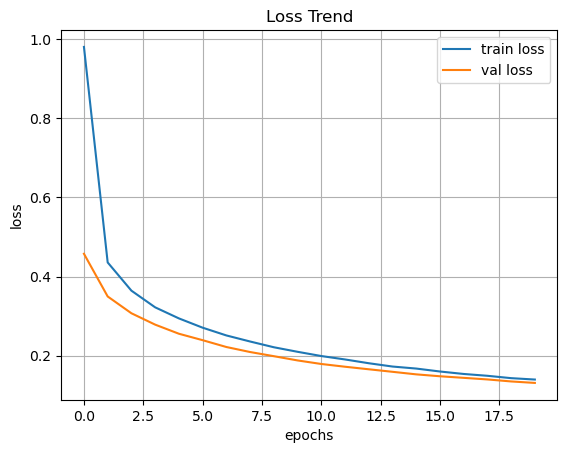

In [13]:
import matplotlib.pyplot as plt

plt.title("Loss Trend")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(train_loss_list, label="train loss")
plt.plot(val_loss_list, label="val loss")
plt.legend(loc='best')

plt.show()

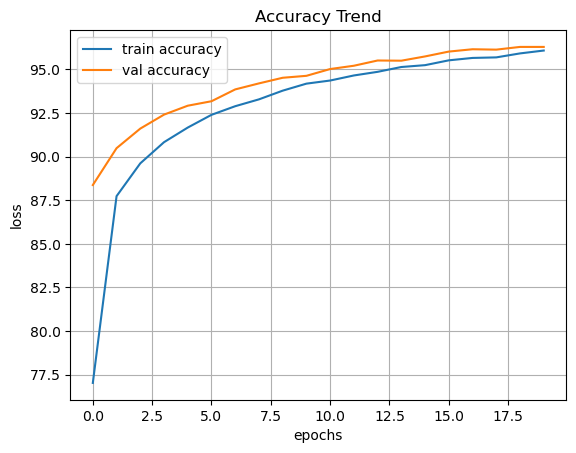

In [14]:
plt.title("Accuracy Trend")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(train_accuracy_list, label="train accuracy")
plt.plot(val_accuracy_list, label="val accuracy")
plt.legend(loc='best')

plt.show()